In [54]:
from dotenv import load_dotenv
load_dotenv()

True

In [55]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=2)]

In [56]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

In [57]:
model = "gpt-3.5-turbo"

In [58]:
prompt = hub.pull("wfh/react-agent-executor")
prompt.pretty_print()

================================ System Message ================================

You are a helpful assistant.

============================= Messages Placeholder =============================

{{messages}}


In [59]:
llm = ChatOpenAI(model=model)

In [60]:
agent_executor = create_react_agent(llm, tools, messages_modifier=prompt)

# Plan

In [61]:
from typing import List, Tuple, Annotated, TypedDict
import operator

class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [62]:
from langchain_core.pydantic_v1 import BaseModel, Field

class Plan(BaseModel):
    """Plan to follow in the future"""
    
    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [63]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import SystemMessage

planner_prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessage(content="""
            For the given objective, come up with a simple step by step plan. \
            This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
            The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps. 
        """),
        MessagesPlaceholder(variable_name="messages")
    ]
)

In [66]:
planner_model = ChatOpenAI(
    model="gpt-4o",
    temperature=0
).with_structured_output(Plan)

planner = planner_prompt | planner_model

In [67]:
planner.invoke(
    { 
        "messages": [
            ("user", "who did Emi bumped into in Katawa Shoujo")
        ]
    }
)

Plan(steps=['Identify the scene where Emi bumps into someone in Katawa Shoujo.', 'Determine the character Emi bumps into in that scene.'])

# Replan

In [68]:
from typing import Union

class Response(BaseModel):
    """Response to user"""
    response: str
    
class Act(BaseModel):
    """Action to perform"""
    action: Union[Response, Plan] = Field(
        description="""
        Action to perform. If you want to respond to user, use Response. \
        If you need to further use tools to get the answer, use Plan.
        """
    )

In [69]:
replanner_prompt = ChatPromptTemplate.from_template(
    """
        For the given objective, come up with a simple step by step plan. \
    This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
    The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.
    
    Your objective was this:
    {input}
    
    Your original plan was this:
    {plan}
    
    You have currently done the follow steps:
    {past_steps}
    
    Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan.
    """
)

In [75]:
replanner_model = ChatOpenAI(model="gpt-4o", temperature=0).with_structured_output(Act)
replanner = replanner_prompt | replanner_model

In [76]:
from typing import Literal

async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": (task, agent_response["messages"][-1].content),
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute) -> Literal["agent", "__end__"]:
    if "response" in state and state["response"]:
        return "__end__"
    else:
        return "agent"

In [77]:
from langgraph.graph import StateGraph

workflow = StateGraph(PlanExecute)

workflow.add_node("planner", plan_step)
workflow.add_node("agent", execute_step)
workflow.add_node("replan", replan_step)

workflow.set_entry_point("planner")

workflow.add_edge("planner", "agent")
workflow.add_edge("agent", "replan")
workflow.add_conditional_edges(
    "replan",
    should_end
)

app = workflow.compile()

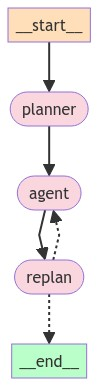

In [78]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [79]:
config = {"recursion_limit": 10}
inputs = {"input": "what is the highest tower in the capital of japan?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Identify the capital of Japan.', 'Research the highest tower located in the capital of Japan.', 'Verify the height and name of the tower to ensure it is the highest.']}


Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")
Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


{'past_steps': ('Identify the capital of Japan.', 'The capital of Japan is Tokyo. It was designated as the capital and is the largest metropolis in Japan.')}
{'plan': ['Research the highest tower located in Tokyo, Japan.', 'Verify the height and name of the tower to ensure it is the highest.']}


Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")
Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


{'past_steps': ('Research the highest tower located in Tokyo, Japan.', 'The highest tower located in Tokyo, Japan is the Tokyo Skytree. It stands at a height of 634 meters (2,080 feet) and was completed in 2012. It is the tallest tower in the world and the tallest structure in Japan.')}
{'response': 'The highest tower in the capital of Japan, Tokyo, is the Tokyo Skytree. It stands at a height of 634 meters (2,080 feet) and was completed in 2012.'}
